In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas_datareader as pdr
import datetime
today = datetime.date.today() #- datetime.timedelta(1)
from matplotlib.ticker import ScalarFormatter
from mpl_toolkits.mplot3d import Axes3D
from Functions import MC_sims

Set up for all the tools

In [3]:
def Get_rfr():
    risk_free_rate = pd.DataFrame()
    shifted_date = 0 # change this if you run this on a non-trading day, just in case
    while risk_free_rate.empty:
        risk_free_rate = pdr.DataReader('DGS3MO', 'fred', today - datetime.timedelta(days=shifted_date)).dropna()
        shifted_date += 1
    return risk_free_rate.values[0][0]/100

In [4]:
def black_scholes(S, K, T, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    if option_type == 'call':
        option_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        option_price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")
    
    return option_price

In [5]:
def Price_projection(ticker,forcast_day):
    n_sims = 2**19
    start_date = today - datetime.timedelta(days=300)
    df = yf.download(ticker,start = start_date)
    MC_sim = MC_sims.MC_simulation(df["Open"],forcast_day,n_sims,simple_mode=False)
    df['rt'] = df["Open"]/df["Open"].shift(1)
    df['sigma'] = df['rt'].rolling(window=30).std()
    df.dropna(inplace=True)
    return MC_sim, df

In [6]:
def Get_option_chain(ticker_symbol,maturity_period):
    try:
        ticker = yf.Ticker(ticker_symbol)
    except Exception as e:
        print(f"Error fetching data for {ticker_symbol}: {e}")
        return None, None
    
    expiration = ticker.options[maturity_period]  # Get the closest option chain
    option_chain = ticker.option_chain(expiration)
    Day_to_expiration = (pd.Timestamp(expiration) - pd.Timestamp(today)).days
    
    calls = option_chain.calls
    puts = option_chain.puts
    calls['contractType'] = "call"
    puts['contractType'] = "put"
    
    print(f'Searching {ticker_symbol} option chain')
    print(f'Expiration: {expiration}')
    for options in [calls,puts]:
        
        options['underlying'] = ticker.info['currentPrice']


        options = options[options['openInterest']>=0]
        options = options[
        (options['strike'] >= 0.5 * options['underlying']) &
        (options['strike'] <= 1.5 * options['underlying'])
        ]
        options.reset_index(drop=True, inplace=True)
        assert options['strike'].duplicated().sum() == 0 #debug
    
    print(f'Number of valid contract: {len(calls)+len(puts)}')
    
    return calls,puts, Day_to_expiration

The idea is very simple:
Run MC sims until maturaity, then use it to construct a propability distribution $P(S)$ where $S$ is the stock price. This model don't require parameters such as volatility $\sigma$.
The price of the options $V(K,t)$ is then calculated using:
$$
C(K,t) = \mathrm{max}( P(S_t>K)*(S_t-K e^{-r(T-t)}), 0 )
$$
for call and 
$$
P(K,t) = C(K,t) - S_t + K e^{-r(T-t)}
$$
for put using call-put parity.

In [8]:
def Option_probability(ticker_symbol, maturity_period=0):
    options,_, Day_to_expiration = Get_option_chain(ticker_symbol, maturity_period)
    
    Price_forecast, historical_stock_price = Price_projection(ticker_symbol, Day_to_expiration)
    n_sim = Price_forecast.shape[0]
    future_probabilities = {strike: [] for strike in options['strike']}

    for t in range(1, Day_to_expiration+1):
        P_day_t = np.zeros(len(options))
        forecast_day_t = Price_forecast[:, t]
        
        # Define P(S_t>K) conditions, only need to look at either call or put
        condition = (options['strike'].values < forecast_day_t[:, np.newaxis])
        P_day_t += np.sum(condition, axis=0)
        P_day_t /= n_sim
        assert P_day_t.all() <= 1 #debug
        
        for idx, strike in enumerate(options['strike']):
            future_probabilities[strike].append(P_day_t[idx])

    probabilities_df = pd.DataFrame(future_probabilities).T
    probabilities_df.index.name = 'strike'
    probabilities_df.columns = [f'P(S>K) day {t}' for t in range(1, Day_to_expiration + 1)]
    return options, probabilities_df, historical_stock_price

Calculate the MC price and compare to Black-Schole.

In [23]:
def plot_option_prices_with_ratio(S_t, MC_prices_df, BS_prices_df,title):
    fig1 = plt.figure(figsize=(10, 8)) 
    
    # Create gridspec with 3 rows, the first two for the option prices and the last for the ratio
    gs = fig1.add_gridspec(2, 1, height_ratios=[6, 2])  # Top plots take more space, lower ratio plot is smaller
    

    ax1 = fig1.add_subplot(gs[0, 0])
    MC_prices_df['Price day 1'].plot(ax=ax1, label='MC Price')
    BS_prices_df['Price day 1'].plot(ax=ax1, label='Black-Scholes')
    ax1.axvline(x=S_t, color='red', linestyle='--', label=f'Spot Price: {S_t}')
    ax1.set_xlim(0.95 * S_t, 1.05 * S_t)
    ax1.set_title(title)
    ax1.set_ylabel('Option Price')
    ax1.set_xticklabels([])
    ax1.legend()
    
    #ratio plot
    ax2 = fig1.add_subplot(gs[1, 0])
    ratio = MC_prices_df['Price day 1'] / BS_prices_df['Price day 1']
    ratio.plot(ax=ax2, label='MC/BS Price Ratio')
    ax2.axvline(x=S_t, color='red', linestyle='--')
    ax2.set_xlim(0.95 * S_t, 1.05 * S_t)
    ax2.set_xlabel('Strike Price')
    ax2.set_ylabel('Ratio')
    ax2.legend()
    
    # Display the figure
    plt.tight_layout()
    plt.show()

In [25]:
def MC_option_pricing_with_index(ticker_symbol,plot=True):
    options, probabilities_df, historical_stock_price = Option_probability(ticker_symbol)
    risk_free_rate = Get_rfr()
    S_t = options['underlying'].iloc[0]
    Day_to_expiration = len(probabilities_df.columns)
    
    call_prices = {}
    put_prices = {}
    
    call_price_BS = {}
    put_price_BS = {}
    for strike in probabilities_df.index:
        call_prices[strike] = []
        put_prices[strike] = []
        
        call_price_BS[strike] = []
        put_price_BS[strike] = []
        
        for t in range(1, Day_to_expiration + 1):
            P_S_gt_K = probabilities_df.loc[strike, f'P(S>K) day {t}']
            
            time_to_maturity = (Day_to_expiration - t) / 365
            discount_factor = np.exp(-risk_free_rate * time_to_maturity)
            
            call_price = max(P_S_gt_K * (S_t - strike * discount_factor),0)
            call_prices[strike].append(call_price)
            
            put_price = call_price - S_t + strike * discount_factor
            put_prices[strike].append(put_price)

            call_BS = black_scholes(S_t, strike, time_to_maturity, risk_free_rate, historical_stock_price['sigma'].iloc[-1], option_type='call')
            put_BS = black_scholes(S_t, strike, time_to_maturity, risk_free_rate, historical_stock_price['sigma'].iloc[-1], option_type='put')
            call_price_BS[strike].append(call_BS)
            put_price_BS[strike].append(put_BS)
            
    call_prices_df = pd.DataFrame(call_prices).T
    put_prices_df = pd.DataFrame(put_prices).T
    
    call_prices_df.columns = [f'Price day {t}' for t in range(1, Day_to_expiration + 1)]
    put_prices_df.columns = [f'Price day {t}' for t in range(1, Day_to_expiration + 1)]

    call_prices_BS_df = pd.DataFrame(call_price_BS).T
    put_prices_BS_df = pd.DataFrame(put_price_BS).T

    call_prices_BS_df.columns = [f'Price day {t}' for t in range(1, Day_to_expiration + 1)]
    put_prices_BS_df.columns = [f'Price day {t}' for t in range(1, Day_to_expiration + 1)]
            
    if plot:
        plot_option_prices_with_ratio(S_t, call_prices_df, call_prices_BS_df,'Call price')
        plot_option_prices_with_ratio(S_t, put_prices_df, put_prices_BS_df,'Put price')
    
    return call_prices_df, put_prices_df

[*********************100%%**********************]  1 of 1 completed

Searching TSLA option chain
Expiration: 2024-11-22
Number of valid contract: 290



/var/folders/8d/cgrbd3xs3m97xzpgj1zs6j1m0000gn/T/ipykernel_70604/1006372048.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))


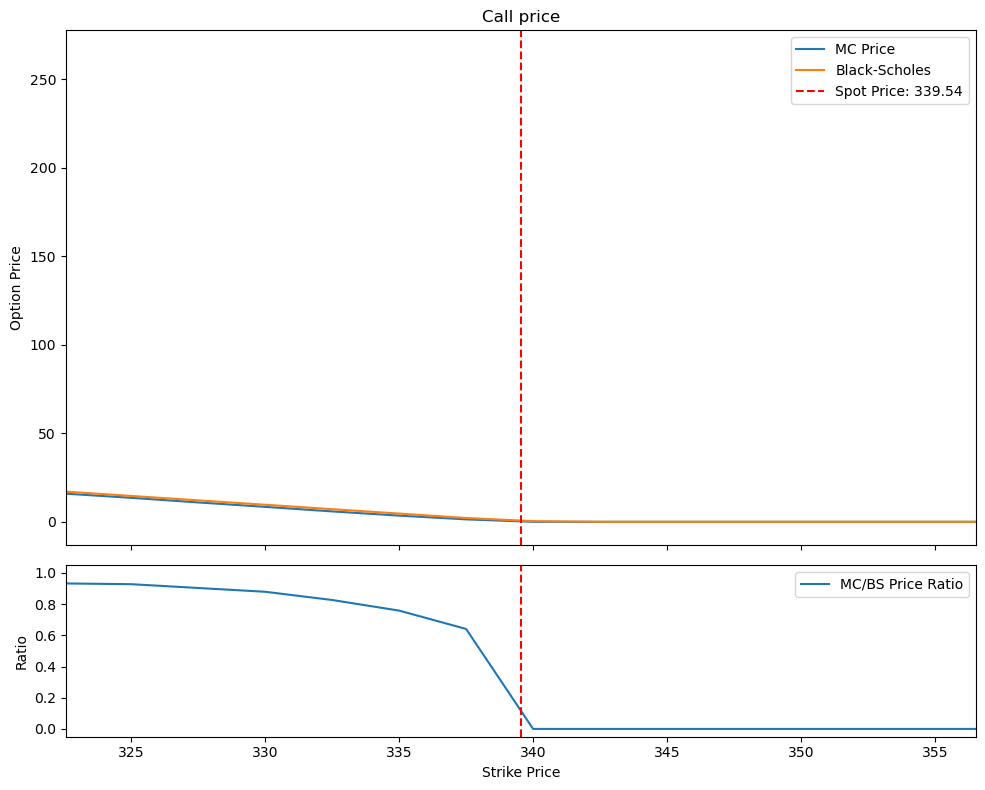

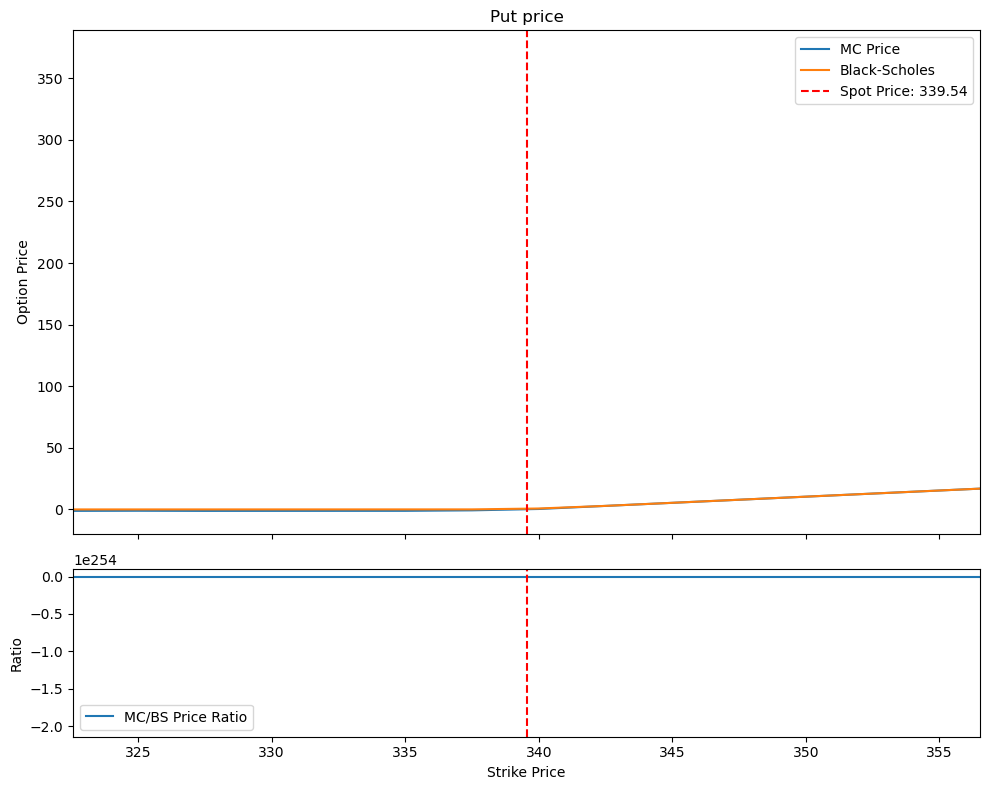

In [27]:
call_prices, put_prices = MC_option_pricing_with_index("TSLA")